In [33]:
import pandas as pd
data = pd.read_csv("/content/cleaned_data.csv")
data.head()

,lemmatized,Annotation 1,Annotation 2
0,paper describes generic framework generating c...,Theory Proposal,Theory Proposal
1,present simple unsupervised robust accurate sy...,New Algorithm/ Method,New Algorithm/ Method
2,present largescale indepth computational reada...,Resources,Resources
3,worked annotated corpus human tutoring session...,New Algorithm/ Method,New Algorithm/ Method
4,discus one aspect essaywriting namely style pr...,Theory Proposal,Theory Proposal


In [34]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(data['lemmatized'], data['Annotation 1'], test_size=0.2)

In [35]:
corpus = x_train

In [36]:
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

In [37]:
import gensim

In [38]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [39]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

In [40]:
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

In [41]:
x_train_embeded = kprocessing.sequence.pad_sequences(lst_text2seq,
                    maxlen=100, padding="post", truncating="post")

In [42]:
len(x_train_embeded[5])

100

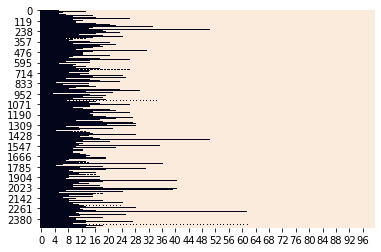

In [43]:
import seaborn as sns
sns.heatmap(x_train_embeded==0, vmin=0, vmax=1, cbar=False)

In [44]:
corpus_test = x_test

In [45]:
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)

In [46]:
lst_text2seq_test = tokenizer.texts_to_sequences(lst_corpus_test)

In [47]:
x_test_embeded = kprocessing.sequence.pad_sequences(lst_text2seq_test, maxlen=100,
             padding="post", truncating="post")

In [48]:
import numpy as np
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

In [49]:
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [51]:
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

In [52]:
x_in = layers.Input(shape=(100,))

In [53]:
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=100, trainable=False)(x_in)

In [54]:
x = attention_layer(x, neurons=100)

In [55]:
x = layers.Bidirectional(layers.LSTM(units=100, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=100, dropout=0.2))(x)

In [56]:
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(9, activation='softmax')(x)

In [57]:
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [58]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     1964700     input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 300, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300, 100)     10100       permute_1[0][0]                  
_______________________________________________________________________________________

In [59]:
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
y_train

array([5, 6, 4, ..., 1, 6, 6])

In [61]:
training = model.fit(x=x_train_embeded, y=y_train, batch_size=32, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

In [62]:
predicted_prob = model.predict(x_test_embeded)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]
predicted

['Theory Proposal',
 'Performance Evaluation',
 'Theory Proposal',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Dataset Creation',
 'Performance Evaluation',
 'Theory Proposal',
 'Theory Proposal',
 'Theory Proposal',
 'Theory Proposal',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Theory Proposal',
 'Theory Proposal',
 'Performance Evaluation',
 'Performance Evaluation',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Theory Proposal',
 'Theory Proposal',
 'New Algorithm/ Method',
 'Performance Evaluation',
 'New Algorithm/ Method',
 'Theory Proposal',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Theory Proposal',
 'Performance Evaluation',
 'Performance Evaluation',
 'Theory Proposal',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Theory Proposal',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Theory Proposal',
 'New Algorithm/ Method',
 'New Algorithm/ Method',
 'Performance Evaluati

In [63]:
y_test_encoded = pd.get_dummies(y_test)
y_test_list = y_test_encoded.values
type(y_test_list)

numpy.ndarray

In [64]:
predicted_prob[0], y_test_list[0]

(array([0.06650553, 0.05824307, 0.04276919, 0.11914638, 0.09963378,
        0.16973317, 0.140521  , 0.02958649, 0.27386138], dtype=float32),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8))

In [65]:
from sklearn import metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.35
Auc: 0.67
Detail:
                               precision    recall  f1-score   support

Algorithm/Method Optimization       0.00      0.00      0.00        26
                 Applications       0.00      0.00      0.00        17
             Dataset Creation       0.83      0.12      0.21        42
           Model Optimization       0.00      0.00      0.00        41
               Model Proposal       0.00      0.00      0.00        83
        New Algorithm/ Method       0.40      0.66      0.50       161
       Performance Evaluation       0.29      0.48      0.36        73
                    Resources       0.00      0.00      0.00        22
              Theory Proposal       0.30      0.44      0.36       156

                     accuracy                           0.35       621
                    macro avg       0.20      0.19      0.16       621
                 weighted avg       0.27      0.35      0.28       621



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


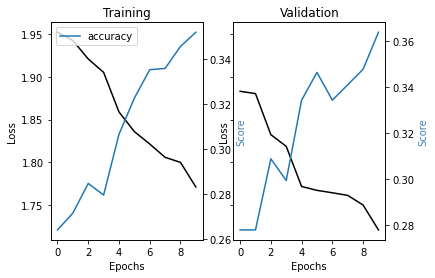

In [66]:
import matplotlib.pyplot as plt
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()